## Convolutional Neural Networks (CNNs) Project: Dog Identification App 

### Why We're Here 

In this notebook, we develop an algorithm that could be used as part of a mobile or web app.  The algorithm will accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most resembling. The image below displays potential sample output of the project. 

<img src="images/my_maltese.png" width="400">

### The Road Ahead

The notebook is broken into separate steps.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/dog_images/train')
valid_files, valid_targets = load_dataset('data/dog_images/valid')
test_files, test_targets = load_dataset('data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


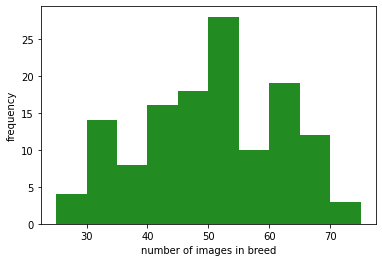

In [3]:
import matplotlib.pyplot as plt

# plot histogram of number of images in each breed
plt.hist(train_targets.sum(axis=0), bins=range(25,80,5), color='forestgreen')
plt.xlabel('number of images in breed')
plt.ylabel('frequency')
plt.savefig('images/breed_frequency.png')

In [4]:
min_freq = min(train_targets.sum(axis=0))
max_freq = max(train_targets.sum(axis=0))

least_freq_breed = dog_names[np.argmin(train_targets.sum(axis=0))].split('.')[-1].replace('_', ' ')
most_freq_breed = dog_names[np.argmax(train_targets.sum(axis=0))].split('.')[-1].replace('_', ' ')

print('The dog breed that has the least data is {}, with {} images.'.format(least_freq_breed, min_freq))
print('The dog breed that has the most data is {}, with {} images.'.format(most_freq_breed, max_freq))

The dog breed that has the least data is Norwegian buhund, with 26.0 images.
The dog breed that has the most data is Alaskan malamute, with 77.0 images.


In [5]:
# save dog names to file in app folder
with open ('../app/dog_names.txt', 'w') as f:
    for name in dog_names:
        name = name.split('.')[-1].replace('_', ' ')
        f.write("{}\n".format(name))

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [6]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  One of these detectors is downloaded and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


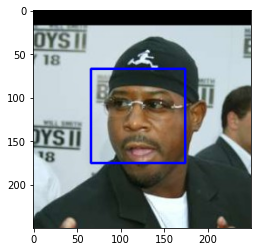

In [7]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[4])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [8]:
def face_detector(img_path):
    
    '''
    Input:
    img_path: string-valued file path to a color image 
    
    Output:
    "True" if at least one face is detected in image stored at img_path
    "False" is no face is detected
    '''
    
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    
    return len(faces) > 0

### Assess the Human Face Detector

The code cell below tests the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

In [9]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# Test the performance of the face_detector algorithm on the images 
# in human_files_short and dog_files_short.
human_result = []
dog_result = []
for i in range(100):
    human_result.append(face_detector(human_files_short[i]))
    dog_result.append(face_detector(dog_files_short[i]))
    
print('{}% of human images have a detected face.'.format(sum(human_result)))
print('{}% of dog images have a detected face.'.format(sum(dog_result)))

100% of human images have a detected face.
12% of dog images have a detected face.


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet import ResNet50

# define ResNet50 model
ResNet50_model_orig = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    
    '''
    Input:
    img_path: string-valued file path to a color image 
    
    Output:
    a 4D tensor suitable for supplying to a Keras CNN with shape (1,224,224,3)
    '''
    
    # load RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    
    '''
    Input:
    img_paths: a numpy array of string-valued image paths
    
    Output:
    a 4D tensor with shape (nb_samples,224,224,3), where nb_samples is the number of images
    '''
    
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet import preprocess_input

def ResNet50_predict_labels(img_path):
    
    '''
    Input:
    img_path: string-valued file path to a color image 
    
    Output:
    prediction vector by ResNet50 for image located at img_path
    '''

    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model_orig.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
def dog_detector(img_path):
    
    '''
    Input:
    img_path: string-valued file path to a color image 
    
    Output:
    "True" if a dog is detected in image stored at img_path
    "False" is no dog is detected
    '''
    
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

In the cell below, we test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [10]:
# Test the performance of the dog_detector function on the images 
# in human_files_short and dog_files_short.
human_result2 = []
dog_result2 = []
for i in range(100):
    human_result2.append(dog_detector(human_files_short[i]))
    dog_result2.append(dog_detector(dog_files_short[i]))
    
print('{}% of human images have a detected dog.'.format(sum(human_result2)))
print('{}% of dog images have a detected dog.'.format(sum(dog_result2)))

2021-08-28 13:51:32.811573: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


0% of human images have a detected dog.
100% of dog images have a detected dog.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we create a CNN that classifies dog breeds from scratch, which has a test accuracy of at least 1%.  

The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  The vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | - | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="220"> | <img src="images/Labrador_retriever_06449.jpg" width="200">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  


### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|█████████████████████████████████████████| 836/836 [00:18<00:00, 44.30it/s]


### Model Architecture

In [10]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, activation='relu', input_shape=(224,224,3))) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(filters=32, kernel_size=2, activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(filters=64, kernel_size=2, activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

2021-08-30 16:01:28.906303: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In this CNN, the first layer is a convolutional layer, which extracts the various features from the input image. In this layer, several convolution kernels are applied to the input, and the output is referred to as the Feature Map.

The convolutional layer is usually followed by a pooling layer, which is primarily used to decrease the size of the convolved feature map hence reducing computational costs. Pooling methods include average pooling (smoothing out the image) and max pooling (extracting brighter pixels). 

We repeat the above combination of the two layers 3 times to extract more features and increase model complexity. Given complex training data, we need correspondingly complex CNN structure to guarantee accuracy. But increasing the depth of a CNN may also cause overfitting, so we need to be careful with adding layers.

The second to last layer is a global pooling layer, which reduces the dimensionality of the data from 3d to 1d. This transforms the data in preparation for the very last fully connected (dense) layer.

The last layer is a fully connected layer. We specify the output size to be 133 since we need to map the data to exactly 133 categories. We apply the softmax activation function. This needs to be the last step of the CNN since it normalizes the output of a network to a probability distribution over predicted output classes. The class with the highest probability will be the predicted class.

### Compile the Model

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

The model is trained in the code cell below. Model checkpointing is used to save the model that attains the best validation loss.

You may also [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). 

In [14]:
from keras.callbacks import ModelCheckpoint  

# specify the number of epochs that you would like to use to train the model.
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/10
334/334 [==============================] - 85s 250ms/step - loss: 4.8840 - accuracy: 0.0096 - val_loss: 4.8697 - val_accuracy: 0.0108

Epoch 00001: val_loss improved from inf to 4.86970, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/10
334/334 [==============================] - 85s 254ms/step - loss: 4.8701 - accuracy: 0.0117 - val_loss: 4.8595 - val_accuracy: 0.0108

Epoch 00002: val_loss improved from 4.86970 to 4.85952, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/10
334/334 [==============================] - 89s 267ms/step - loss: 4.8414 - accuracy: 0.0154 - val_loss: 4.8138 - val_accuracy: 0.0180

Epoch 00003: val_loss improved from 4.85952 to 4.81382, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/10
334/334 [==============================] - 86s 255ms/step - loss: 4.7729 - accuracy: 0.0205 - val_loss: 4.7683 - val_accuracy: 0.0192

Epoch 00004: val_loss improved from 4.81382 to 4.76835, saving model to 

### Load the Model with the Best Validation Loss

In [15]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  We see that test accuracy is greater than 1%.

In [16]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.3062%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds (using Transfer Learning)

Firstly, we show how to train a CNN using transfer learning to reduce training time without sacrificing accuracy. We use the pretrained VGG16 network in this example.

### Obtain Bottleneck Features

In [17]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [18]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [19]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the Model

In [20]:
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
334/334 [==============================] - 1s 3ms/step - loss: 7.4405 - accuracy: 0.2576 - val_loss: 3.4801 - val_accuracy: 0.4587

Epoch 00001: val_loss improved from inf to 3.48012, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
334/334 [==============================] - 1s 2ms/step - loss: 1.7081 - accuracy: 0.6551 - val_loss: 2.5532 - val_accuracy: 0.5725

Epoch 00002: val_loss improved from 3.48012 to 2.55319, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
334/334 [==============================] - 1s 2ms/step - loss: 0.8304 - accuracy: 0.7898 - val_loss: 2.1567 - val_accuracy: 0.6084

Epoch 00003: val_loss improved from 2.55319 to 2.15673, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
334/334 [==============================] - 1s 2ms/step - loss: 0.4559 - accuracy: 0.8714 - val_loss: 1.9707 - val_accuracy: 0.6359

Epoch 00004: val_loss improved from 2.15673 to 1.97069, saving model to saved_models/weights.best.VGG16.h

### Load the Model with the Best Validation Loss

In [21]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [22]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 69.3780%


### Predict Dog Breed with the Model

In [23]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    
    '''
    Input:
    img_path: string-valued file path to a color image 
    
    Output:
    breed: breed of dog in input image predicted by CNN trained on top of the VGG16 neural network.
    '''
    
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    breed = dog_names[np.argmax(predicted_vector)]
    breed = breed.split('.')[-1].replace('_', ' ')
    return breed

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You now use transfer learning to create a CNN that can identify dog breed from images.  This CNN attains 81.81% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we use the bottleneck features from a different pre-trained model. Out of the following pre-computed the features for all of the networks that are currently available in Keras, we choose the `InceptionV3` network:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [InceptionV3](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The corresponding bottleneck features `DogInceptionV3Data.npz` are downloaded and stored in the `bottleneck_features` folder in the repository.

### Obtain Bottleneck Features

In [10]:
# Obtain bottleneck features from pretrained InceptionV3 CNN.
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

### Model Architecture

Create a CNN to classify dog breed.  

In [31]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from keras.models import Sequential

# Define architecture
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


InceptionV3 is a convolutional neural network for assisting in image analysis and object detection. Its output size is (5, 5, 2048). Hence we first need a global pooling layer to transform the 3D output to 1D, and then a fully connected layer with SoftMax activation to map to the 133 dog breed classes for probabilities.

### Compile the Model

In [32]:
# Compile the model (alternative optimizer: rmsprop)
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

### Train the Model

The model is trained in the code cell below.  Model checkpointing is used to save the model that attains the best validation loss.  

In [33]:
from keras.callbacks import ModelCheckpoint  

# Train the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
334/334 [==============================] - 1s 3ms/step - loss: 1.2047 - accuracy: 0.7012 - val_loss: 0.7188 - val_accuracy: 0.7988

Epoch 00001: val_loss improved from inf to 0.71882, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 2/20
334/334 [==============================] - 1s 3ms/step - loss: 0.3886 - accuracy: 0.8746 - val_loss: 0.7233 - val_accuracy: 0.8168

Epoch 00002: val_loss did not improve from 0.71882
Epoch 3/20
334/334 [==============================] - 1s 3ms/step - loss: 0.2383 - accuracy: 0.9201 - val_loss: 0.6392 - val_accuracy: 0.8287

Epoch 00003: val_loss improved from 0.71882 to 0.63917, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 4/20
334/334 [==============================] - 1s 3ms/step - loss: 0.1665 - accuracy: 0.9452 - val_loss: 0.6710 - val_accuracy: 0.8407

Epoch 00004: val_loss did not improve from 0.63917
Epoch 5/20
334/334 [==============================] - 1s 3ms/step - loss: 0.1116 - accuracy: 0.9660 

### Load the Model with the Best Validation Loss

In [34]:
# Load the model weights with the best validation loss.
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [35]:
# Calculate classification accuracy on the test dataset
# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.8182%


### Predict Dog Breed with the Model

We write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, the function has three steps:
1. Extract the bottleneck features corresponding to InceptionV3 model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding the `InceptionV3` architecture, we need to use the function

    extract_InceptionV3

In [36]:
# Write a function that takes a path to an image as input and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def InceptionV3_predict_breed(img_path):
    
    '''
    Input:
    img_path: string-valued file path to a color image 
    
    Output:
    breed: breed of dog in input image predicted by CNN trained on top of the InceptionV3 neural network
    '''
        
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    breed = dog_names[np.argmax(predicted_vector)]
    breed = breed.split('.')[-1].replace('_', ' ')
    
    return breed

---
<a id='step6'></a>
## Step 6: Inplement Dog Breed Classification Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.

In [37]:
def classify_dog_breed(img_path):
    
    '''
    Input:
    img_path: string-valued file path to a color image
    
    Output:
        - if a dog is detected in the image, the predicted breed is printed
        - else if a human is detected in the image, the resembling dog breed is printed
        - if neither is detected in the image, an error message is printed
    '''
    
    img = image.load_img(img_path)
    plt.imshow(img)
    
    if dog_detector(img_path):
        breed = InceptionV3_predict_breed(img_path)
        print('I detect a {} dog!'.format(breed))

    elif face_detector(img_path):
        breed = InceptionV3_predict_breed(img_path)
        print('I detect a human face resembling a {} dog!'.format(breed))
        
    else:
        print("Sorry, I can only classify a dog or a human!")   

---
<a id='step7'></a>
## Step 7: Test the Algorithm

In this section, we take the new algorithm for a spin! 

Firstly, I want to test the algorithm on my own Maltese dog to see whether it can predict the breed correctly.

I detect a Bichon frise dog!


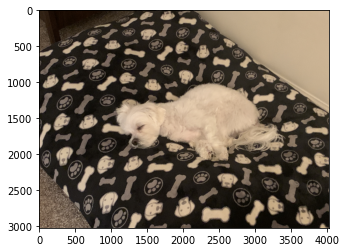

In [38]:
classify_dog_breed('../app/static/IMG_5040.jpeg')

The algorithm says that my dog is a Bichon frise. Although the prediction is not correct, we do notice that at first sight the breed do look similar because of their white color. Although both are small dogs, Bichon frise is slightly larger and weighs about twice as Maltese. The size difference, however, is hard to be shown in photos.

The biggest difference between the breeds is with their hair. Bichon frise has strong and dense curly hair. In general, the breed has shorter hair, which gives the dog a very spongy appearance if trimmed and treated. On the other hand, Maltese has smooth, thin and straight hair that can grow very long, as shown in the picture below. The majority of the Maltese images in the training set are similar to this picture.

However, if Maltese hair is groomed and trimmed, such as in the photo of my dog above, the difference between Bichon frise and Maltese is no longer very obvious.

Bichon frise | Maltese
- | -
<img src="images/Bichon_frise.jpg" width="250"> | <img src="images/Maltese.jpg" width="280">

Next, I want to supply the dog breed classifier with another photo of my dog. This time, my dog's hair is left ungroomed for a while, which makes my dog look similar to the Maltese images in the training set. We will see how the model behaves.

I detect a Maltese dog!


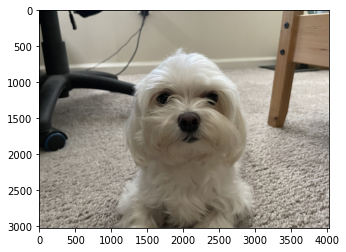

In [39]:
classify_dog_breed('../app/static/IMG_1679.jpeg')

This time, the model is able to correctly identify the breed of my dog!

Next, I will supply the model with a photo of my dog lying on his back and wearing an Elizabeth collar.

Sorry, I can only classify a dog or a human!


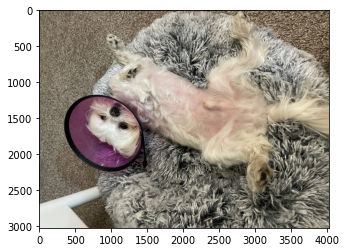

In [40]:
classify_dog_breed('../app/static/IMG_1257.jpeg')

But the ResNet50 dog detector is not able to detect a dog in the picture, hence the photo is not passed to the CNN classifier. What happens if we feed the photo directly to the InceptionV3 CNN classifier?

In [41]:
InceptionV3_predict_breed('../app/static/IMG_1257.jpeg')

'Dachshund'

But a Maltese looks nothing like a Dachshund!

Dachshund |
- |
<img src="images/Dachshund.jpg" width="200"> |

I would also like to know what my model predicts to be the breed of a doge emoji. But unfortunately, the ResNet50 dog detector fails again so I need to feed the emoji directly to the InceptionV3 CNN.

Sorry, I can only classify a dog or a human!


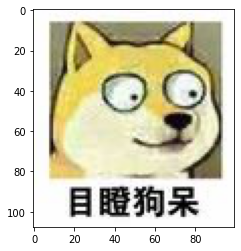

In [42]:
classify_dog_breed('../app/static/IMG_5051.jpeg')

In [43]:
InceptionV3_predict_breed('../app/static/IMG_5051.jpeg')

'Akita'

The doge emoji is based on a Shiba Inu, but the CNN predicts that it is an Akita. What is worth noting, however, is that Shiba Inu is not one of the 133 dog breeds of the data set! Hence Akita is a reasonable prediction. After all, it's sometimes hard for some people to differetiate between an Akita and a Shiba Inu!

Akita |
- |
<img src="images/Akita.jpg" width="200">

I am also interested in how the model performs on human photos. Therefore, I feed it with my own photo.

I detect a human face resembling a Dachshund dog!


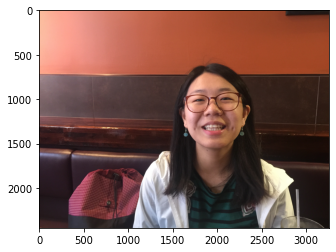

In [44]:
classify_dog_breed('../app/static/IMG_5351.jpeg')

I detect a human face resembling a Dachshund dog!


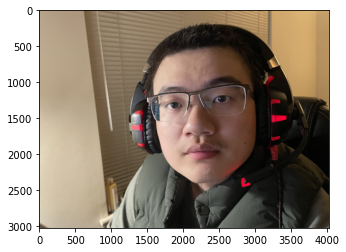

In [45]:
classify_dog_breed('../app/static/IMG_0061.jpeg')

The model says that we both look like a Dachshund!

Dachshund |
- |
<img src="images/Dachshund.jpg" width="200"> |

It is very interesting that the model predicts both human faces to be Dachshund, and so is my dog in an Elizabeth colloar. My guess is that the model is inclined to classify images that do not look like typical dogs as Dachshunds.

The outputs are not so different from what I expected. At an accuracy rate of nearly 82% percent, I did not expect the dog classification results to be perfect -- there might be nuances that the model cannot capture. Regarding classification results for human, there is no way to evaluate whether they are correct or not, only subjective opinions.

To further improve the algorithm, there are a few things we could do:
- Balance the categories of the training set may further improve the model. The training data set is not well balanced for some breeds, e.g., there are only 31 samples of Yorkshire terrier, but 75 samples of Border collie. 
- Augment the training data set by adding synthetic data either through flipping images, adding noise, or other distortions. This will expose our model to more variations and generalize better on data it has not seen.
- Use a different dog detector. The current dog detector is ResNet50, which is trained on images of 1000 categories. It may be too complicated for the simple task of detecting a dog. 